##Model DCGAN##

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/scripts')

In [ ]:
!pip install -r /content/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

In [ ]:
@dataclass
class Config:
  epochs: int = 20
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cfg = Config()
cfg_dict = asdict(cfg)

In [ ]:
sentence_encoder = SentenceEncoder(cfg.device)

  0%|          | 0.00/405M [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [ ]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)

        projected_embed = self.projector(text_embeddings)

        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)

        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [ ]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 256)
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

In [ ]:
generator.load_state_dict(torch.load("/content/drive/MyDrive/generator.pt"))

<All keys matched successfully>

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(
    ['''The lady has high cheekbones and an oval face
      She has wavy hair She has big lips and
      a slightly oper mouth The female is smiling seems attractive,
      young and has heavy makeup She is wearing earrings, lipstick and a necklace
'''])

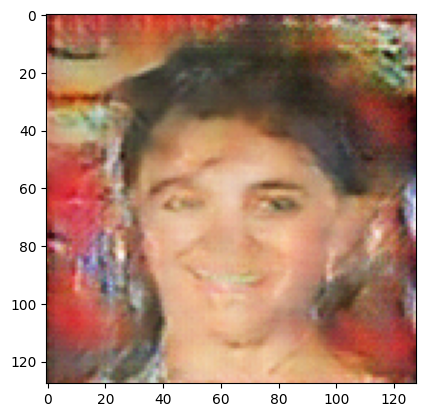

In [ ]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

##Model DFGAN##

In [ ]:
from collections import OrderedDict
import torch.nn.functional as F

In [ ]:
class affine(nn.Module):
  def __init__(self, num_features):
    super(affine, self).__init__()
    self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))

    self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    self._initialize()

  def _initialize(self):
    nn.init.zeros_(self.fc_gamma.linear2.weight.data)
    nn.init.ones_(self.fc_gamma.linear2.bias.data)
    nn.init.zeros_(self.fc_beta.linear2.weight.data)
    nn.init.zeros_(self.fc_beta.linear2.bias.data)

  def forward(self, x, y=None):
    weight = self.fc_gamma(y)
    bias = self.fc_beta(y)

    if weight.dim() == 1:
        weight = weight.unsqueeze(0)
    if bias.dim() == 1:
        bias = bias.unsqueeze(0)

    size = x.size()
    weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
    bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
    return weight * x + bias

In [ ]:
class G_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
      super(G_Block, self).__init__()

      self.learnable_sc = in_ch != out_ch
      self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
      self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
      self.affine0 = affine(in_ch)
      self.affine1 = affine(in_ch)
      self.affine2 = affine(out_ch)
      self.affine3 = affine(out_ch)
      self.gamma = nn.Parameter(torch.zeros(1))
      if self.learnable_sc:
          self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def forward(self, x, y=None):
      return self.shortcut(x) + self.gamma * self.residual(x, y)

    def shortcut(self, x):
      if self.learnable_sc:
          x = self.c_sc(x)
      return x

    def residual(self, x, y=None):
      h = self.affine0(x, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine1(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.c1(h)

      h = self.affine2(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine3(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      return self.c2(h)

In [ ]:
class NetG(nn.Module):
  def __init__(self, ngf = 64, nz = 100):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.nz = nz
    self.fc = nn.Linear(self.nz, self.ngf * 8 * 4 * 4)
    self.reduce_dim = nn.Linear(768, 256)
    self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block2 = G_Block(ngf * 8, ngf * 8)#8x8
    self.block3 = G_Block(ngf * 8, ngf * 8)#16x16
    self.block4 = G_Block(ngf * 8, ngf * 4)#32x32
    self.block5 = G_Block(ngf * 4, ngf)#64x64
    # self.block6 = G_Block(ngf * 2, ngf * 1)#128x128
    self.conv_img = nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf, 3, 3, 1, 1),
            nn.Tanh(),
        )
  def forward(self, x, c):
    out = self.fc(x)
    out = out.view(x.size(0), 8*self.ngf, 4, 4)
    c = self.reduce_dim(c)
    out = self.block0(out,c)
    out = F.interpolate(out, scale_factor=2)
    out = self.block1(out,c)
    out = F.interpolate(out, scale_factor=2)
    out = self.block2(out,c)
    out = F.interpolate(out, scale_factor=2)
    out = self.block3(out,c)
    out = F.interpolate(out, scale_factor=2)
    out = self.block4(out,c)
    out = F.interpolate(out, scale_factor=2)
    out = self.block5(out,c)
    # out = F.interpolate(out, scale_factor=2)
    # out = self.block6(out,c)
    out = self.conv_img(out)
    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
netG = NetG(64, 100).to(device)

In [ ]:
netG.load_state_dict(torch.load("/content/drive/MyDrive/netG.pt"))

<All keys matched successfully>

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['''
The woman has high cheekbones.
She has straight hair which is
brown in colour. She has arched
eyebrows and a slightly open
mouth. The smiling, young attractive woman has heavy makeup. She
is wearing lipstick.
'''])

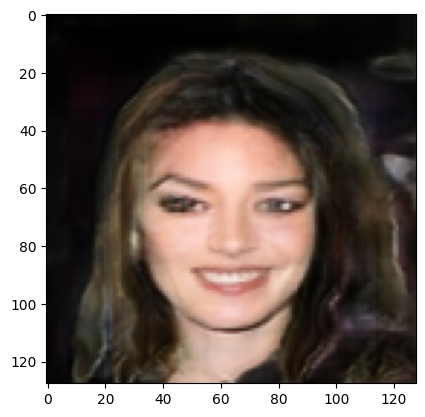

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

##Creating Website##


In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 15.6 MB/s eta 0:00:00


In [ ]:
%%writefile text2face.py
import streamlit as st
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from PIL import Image
import sys
sys.path.append('/content/drive/MyDrive/scripts')
from text_encoder.sentence_encoder import SentenceEncoder

from collections import OrderedDict
import torch.nn.functional as F

from torch.nn import Parameter


# Define the CSS styles
input_style = """
    <style>
    input[type="text"] {
        font-size: 18px;
        color: #333333;
        background-color: #F0F0F0;
        border-radius: 5px;
        padding: 10px;
        margin: 10px 0;
    }
    </style>
    """
@dataclass
class Config:
  epochs: int = 20
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model 1 DCGAN

class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output



def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Inject the CSS styles into the app
st.markdown(input_style, unsafe_allow_html=True)
st.title('Text2Face Generation')
st.write('using GAN models to generate the face')
st.markdown('\n\n\n\n\n\n')
description=st.text_input('Enter the description', placeholder='Search...')

cfg= Config()
cfg_dict = asdict(cfg)

sentence_encoder = SentenceEncoder(cfg.device)

###############################model 1################################
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)
generator.cuda()
generator.load_state_dict(torch.load("/content/drive/MyDrive/generator.pt"))
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings([description])
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
test_image=torchvision.utils.make_grid(test_image, normalize=True, nrow=1)
#show_grid(test_image)
npimg = test_image.numpy()
npimg=np.transpose(npimg,(1,2,0))
plt.imsave('test.png', npimg)
plt.close()
st.markdown(
    """
    <style>
    img {
        width: 250px;
        height: 250px;
        max-width: 50%;

    }
    </style>
    """,
    unsafe_allow_html=True
)
st.write("<h1 style='color: black'>DCGAN</h1>", unsafe_allow_html=True)
st.image('/content/test.png')

###########model 2##############

class affine(nn.Module):
  def __init__(self, num_features):
    super(affine, self).__init__()
    self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))

    self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    self._initialize()

  def _initialize(self):
    nn.init.zeros_(self.fc_gamma.linear2.weight.data)
    nn.init.ones_(self.fc_gamma.linear2.bias.data)
    nn.init.zeros_(self.fc_beta.linear2.weight.data)
    nn.init.zeros_(self.fc_beta.linear2.bias.data)

  def forward(self, x, y=None):
    weight = self.fc_gamma(y)
    bias = self.fc_beta(y)

    if weight.dim() == 1:
        weight = weight.unsqueeze(0)
    if bias.dim() == 1:
        bias = bias.unsqueeze(0)

    size = x.size()
    weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
    bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
    return weight * x + bias







class G_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
      super(G_Block, self).__init__()

      self.learnable_sc = in_ch != out_ch
      self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
      self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
      self.affine0 = affine(in_ch)
      self.affine1 = affine(in_ch)
      self.affine2 = affine(out_ch)
      self.affine3 = affine(out_ch)
      self.gamma = nn.Parameter(torch.zeros(1))
      if self.learnable_sc:
          self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def forward(self, x, y=None):
      return self.shortcut(x) + self.gamma * self.residual(x, y)

    def shortcut(self, x):
      if self.learnable_sc:
          x = self.c_sc(x)
      return x

    def residual(self, x, y=None):
      h = self.affine0(x, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine1(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.c1(h)

      h = self.affine2(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine3(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      return self.c2(h)


class NetG(nn.Module):
  def __init__(self, ngf = 64, nz = 100):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.nz = nz

    self.fc = nn.Linear(self.nz, self.ngf * 8 * 4 * 4)
    self.reduce_dim = nn.Linear(768, 256)
    self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block2 = G_Block(ngf * 8, ngf * 8)#8x8
    self.block3 = G_Block(ngf * 8, ngf * 8)#16x16
    self.block4 = G_Block(ngf * 8, ngf * 4)#32x32
    self.block5 = G_Block(ngf * 4, ngf)#64x64
    # self.block6 = G_Block(ngf * 2, ngf * 1)#128x128

    self.conv_img = nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf, 3, 3, 1, 1),
            nn.Tanh(),
        )

  def forward(self, x, c):
    out = self.fc(x)
    out = out.view(x.size(0), 8*self.ngf, 4, 4)
    c = self.reduce_dim(c)
    out = self.block0(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block1(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block2(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block3(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block4(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block5(out,c)

    # out = F.interpolate(out, scale_factor=2)
    # out = self.block6(out,c)

    out = self.conv_img(out)

    return out



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = NetG(64, 100).to(device)

netG.load_state_dict(torch.load("/content/drive/MyDrive/netG.pt"))
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings([description])
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
test_image=torchvision.utils.make_grid(test_image, normalize=True, nrow=1)
#show_grid(test_image)
npimg = test_image.numpy()
npimg=np.transpose(npimg,(1,2,0))
plt.imsave('test1.png', npimg)
plt.close()
st.markdown(
    """
    <style>
    img {
        width: 250px;
        height: 250px;
        max-width: 50%;

    }
    </style>
    """,
    unsafe_allow_html=True
)
st.write("<h1 style='color: black'>DFGAN</h1>", unsafe_allow_html=True)
st.image('/content/test1.png')




Writing text2face.py


In [ ]:
!pip install pyngrok -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!streamlit run text2face.py & npx localtunnel --port 8501

[..................] | fetchMetadata: sill resolveWithNewModule localtunnel@2.0

npx: installed 22 in 5.171s
your url is: https://two-tigers-itch-34-143-216-42.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.143.216.42:8501

2023-04-30 13:39:10.188846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identica